In [1]:
import torch
from torch_geometric.utils import remove_self_loops, coalesce
from Models.GAE_batch import GAE
# from GAE_1 import Encoder, Decoder, GAE
from torchinfo import summary
from torch_geometric.loader import DataLoader
import numpy as np
import torch.optim as optim
import scipy
import os
import Models.Get_data as Gd
from sklearn.model_selection import train_test_split
import torch.nn as nn
from copy import deepcopy

from tqdm import tqdm  
import matplotlib.pyplot as plt
from kmeans_pytorch import kmeans, kmeans_predict

import random

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(66)  # 你可以选择任意一个数字作为种子
# 启用浮点数异常检测
# torch.autograd.set_detect_anomaly(True)

In [3]:
# 检查是否有 GPU 可用
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

# 检查 GPU 的数量
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

# 获取每个 GPU 的名称
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# 设置默认使用的 GPU 设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

GPU is available
Number of GPUs available: 1
GPU 0: NVIDIA GeForce RTX 4060 Laptop GPU
Using device: cuda:0


In [4]:
directory = '/home/wl4023/data/Sibo_22Mar2024'
folders = [os.path.join(directory, f, 'hessian_') for f in os.listdir(directory) if f.startswith('case_')]

# Get data

In [5]:
xyfile = "/home/wl4023/data/Sibo_22Mar2024/case_0/hessian_/xy_coords.npy"
pos = torch.tensor(np.load(xyfile), dtype=torch.float32)

In [6]:
sparse_graph = scipy.sparse.load_npz('/home/wl4023/data/Sibo_22Mar2024/sparse_matrix_fixed_weighted.npz')
indices = np.array(sparse_graph.nonzero())
values = sparse_graph.data
shape = sparse_graph.shape

# sparse edge tensor
edge_tensor = torch.sparse_coo_tensor(indices, values, shape, dtype=torch.float).coalesce()
edge_index = edge_tensor.indices()
# edge_weight = edge_tensor.values()
# edge_weight = edge_weight.unsqueeze(1)
print(edge_tensor.shape)
print(edge_index)
# print(edge_weight)

torch.Size([97149, 97149])
tensor([[    0,     0,     1,  ..., 97148, 97148, 97148],
        [    1,     3,     0,  ..., 97145, 97146, 97147]])


In [7]:
distance = torch.norm(pos[edge_index[0]]-pos[edge_index[1]], dim=1)
print(distance)

tensor([0.0029, 0.0039, 0.0029,  ..., 0.0024, 0.0021, 0.0024])


In [8]:
edge_weight = 1/(distance)
edge_weight = edge_weight/torch.sum(edge_weight)*1000
edge_weight = edge_weight.unsqueeze(1)
print(f'{edge_weight.max():.8f}, {edge_weight.min():.8f}')

0.02281803, 0.00025737


## Train and val data

In [9]:
dataset, length = Gd.get_all_nodes(folders[:-1])

train_np, val_np = train_test_split(dataset, test_size=0.2, shuffle=True)
train_np = np.expand_dims(train_np[:, :, 0], axis=2)
val_np = np.expand_dims(val_np[:, :, 0], axis=2)

In [10]:
train_tensor = torch.tensor(train_np, dtype=torch.float)
train_tensor_set = Gd.CustomDataset(edge_index, train_tensor, edge_weight, pos)
val_tensor = torch.tensor(val_np, dtype=torch.float)
val_tensor_set = Gd.CustomDataset(edge_index, val_tensor, edge_weight, pos)

In [11]:
train_loader = DataLoader(train_tensor_set, batch_size=5, shuffle=True)
val_loader = DataLoader(val_tensor_set, batch_size=5, shuffle=True)
data_iter = iter(train_loader)
batch = next(data_iter)
# batch = batch.to(device)

In [12]:
len(train_loader)


464

In [13]:
preprocessor = Gd.Preprocessor()
preprocessor.fit(torch.concat((train_tensor, val_tensor), axis=0))

In [14]:
print(preprocessor.mean)
print(preprocessor.std)

tensor(6.9571)
tensor(9.8111)


In [15]:
num_mp_layer=[2, 2, 2]
bounding_box = []
lengthscales = [0.2, 0.5]
if len(lengthscales) > 0:
    x_lo = batch.pos[:,0].min() - lengthscales[0]/2
    x_hi = batch.pos[:,0].max() + lengthscales[0]/2
    y_lo = batch.pos[:,1].min() - lengthscales[0]/2
    y_hi = batch.pos[:,1].max() + lengthscales[0]/2
    bounding_box = [x_lo.cpu().item(), x_hi.cpu().item(), y_lo.cpu().item(), y_hi.cpu().item()]

## Test data

In [16]:
test_np, length = Gd.get_all_nodes(folders[-1:])
test_np = np.expand_dims(test_np[:, :, 0], axis=2)
test_tensor = torch.tensor(test_np, dtype=torch.float)
test_tensor_set = Gd.CustomDataset(edge_index, test_tensor, edge_weight, pos)
test_loader = DataLoader(test_tensor_set, batch_size=1, shuffle=False)

In [17]:
print(folders[-1:])

['/home/wl4023/data/Sibo_22Mar2024/case_23/hessian_']


# Train

In [18]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_true, y_pred):
        return torch.sqrt(self.mse(y_true, y_pred))

class NRMSE(nn.Module):
    def __init__(self, total_dataset):
        super(NRMSE, self).__init__()
        self.rmse = RMSELoss()
        self.factor = total_dataset.max()-total_dataset.min()

    def forward(self, y_true, y_pred):
        return self.rmse(y_true, y_pred)/self.factor

In [19]:
def check_for_nan_or_inf(tensor, name):
    if torch.isnan(tensor).any():
        print(f"Tensor {name} contains NaN values.")
    if torch.isinf(tensor).any():
        print(f"Tensor {name} contains Inf values.")

In [20]:
def train(model, train_loader, val_loader, criterion, optimizer, device, metric_train, metric_val, epochs=30):

    train_NRMSELoss_list = []
    train_RMSELoss_list = []

    val_NRMSELoss_list = []
    val_RMSELoss_list = []
    min_loss = 100000
    # ss = 0
    for i in range(epochs):
        model.train()
        train_loss = 0
        relative_train_loss = 0
        # print(len(train_loader))
        for batch in tqdm(train_loader):
            batch = batch.to(device)

            input = preprocessor.transform(batch.x)

            optimizer.zero_grad()
            predict, _ = model(input, batch.edge_index, batch.edge_attr, batch.pos, batch.batch)
            # print(predict.max(), predict.min(), x.max(), x.min())
            # 在计算损失之前检查输入
            check_for_nan_or_inf(predict, "y_pred")
            check_for_nan_or_inf(input, "y_true")
            loss = criterion(input, predict)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            train_loss += criterion(batch.x, preprocessor.inverse_transform(predict)).item()
            relative_train_loss += metric_train(batch.x, preprocessor.inverse_transform(predict)).item()

        train_loss = train_loss/len(train_loader)
        relative_train_loss /= len(train_loader)
        train_RMSELoss_list.append(train_loss)
        train_NRMSELoss_list.append(relative_train_loss)

        model.eval()
        with torch.no_grad():
            val_loss = 0
            relative_val_loss = 0
            for batch in val_loader:
                batch = batch.to(device)
                input = preprocessor.transform(batch.x)

                predict, _ = model(input, batch.edge_index, batch.edge_attr, batch.pos, batch.batch)

                loss = criterion(input, predict)
                val_loss += criterion(batch.x, preprocessor.inverse_transform(predict)).item()
                relative_val_loss += metric_val(batch.x, preprocessor.inverse_transform(predict)).item()


            val_loss /= len(val_loader)
            relative_val_loss /= len(val_loader)

            val_RMSELoss_list.append(val_loss)
            val_NRMSELoss_list.append(relative_val_loss)

        print(f'Epoch {i + 1}/{epochs}, train Loss: {train_loss}, NRMSE_train_loss: {relative_train_loss}, val Loss: {val_loss}, NRMSE_val_loss: {relative_val_loss}')
        if min_loss >= relative_val_loss:
            min_loss = relative_val_loss
            torch.save(model.state_dict(), 'GAE_kmeans.pth')

    return train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list

In [21]:
# Define the weights initialization function
def initialize_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

In [22]:
model = GAE(1, 16, 1, 2, num_mp_layer, lengthscales, bounding_box)
model.apply(initialize_weights)
summary(model, input_data=(batch.x, batch.edge_index, batch.edge_attr, batch.pos, batch.batch))


Layer (type:depth-idx)                   Output Shape              Param #
GAE                                      [485745, 1]               --
├─Encoder: 1-1                           [45, 16]                  --
│    └─Linear: 2-1                       [485745, 16]              32
│    └─ELU: 2-2                          [485745, 16]              --
│    └─Linear: 2-3                       [1455160, 16]             32
│    └─ELU: 2-4                          [1455160, 16]             --
│    └─ModuleList: 2-68                  --                        (recursive)
│    │    └─ModuleList: 3-9              --                        (recursive)
│    └─ELU: 2-6                          [1455160, 16]             --
│    └─ModuleList: 2-68                  --                        (recursive)
│    │    └─ModuleList: 3-9              --                        (recursive)
│    └─ModuleList: 2-69                  --                        (recursive)
│    │    └─ModuleList: 3-10            

In [23]:
criterion = RMSELoss()
optimizer = optim.Adam(model.parameters())
metric_train = NRMSE(train_tensor)
metric_val = NRMSE(val_tensor)
model.to(device)
train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list = train(model,
                                                                                         train_loader,
                                                                                         val_loader,
                                                                                         criterion,
                                                                                         optimizer,
                                                                                         device,
                                                                                         metric_train,
                                                                                         metric_val, 
                                                                                         epochs=50)

100%|██████████| 464/464 [01:56<00:00,  3.97it/s]


Epoch 1/50, train Loss: 5.073524759761218, NRMSE_train_loss: 0.0975101317543986, val Loss: 4.586874641221145, NRMSE_val_loss: 0.08838607118754037


100%|██████████| 464/464 [01:55<00:00,  4.01it/s]


Epoch 2/50, train Loss: 4.378439065711252, NRMSE_train_loss: 0.08415099774519431, val Loss: 4.147873527017133, NRMSE_val_loss: 0.07992680733702306


100%|██████████| 464/464 [01:54<00:00,  4.04it/s]


Epoch 3/50, train Loss: 3.8875139861785133, NRMSE_train_loss: 0.07471570942213694, val Loss: 3.6711294579094855, NRMSE_val_loss: 0.07074026132387848


100%|██████████| 464/464 [01:55<00:00,  4.01it/s]


Epoch 4/50, train Loss: 3.6555826990254996, NRMSE_train_loss: 0.07025812780243698, val Loss: 3.518797032791993, NRMSE_val_loss: 0.06780491497945683


100%|██████████| 464/464 [01:53<00:00,  4.10it/s]


Epoch 5/50, train Loss: 3.4133907755644155, NRMSE_train_loss: 0.06560334292489328, val Loss: 3.4119637002205025, NRMSE_val_loss: 0.06574630657018259


100%|██████████| 464/464 [01:47<00:00,  4.34it/s]


Epoch 6/50, train Loss: 3.2992562068433595, NRMSE_train_loss: 0.0634097444206669, val Loss: 3.2252056865856567, NRMSE_val_loss: 0.0621476019893227


100%|██████████| 464/464 [01:52<00:00,  4.13it/s]


Epoch 7/50, train Loss: 3.16313628210076, NRMSE_train_loss: 0.06079360026593224, val Loss: 3.149762504059693, NRMSE_val_loss: 0.06069386143494269


100%|██████████| 464/464 [01:53<00:00,  4.09it/s]


Epoch 8/50, train Loss: 3.045367192605446, NRMSE_train_loss: 0.05853014850410922, val Loss: 3.0671526013777175, NRMSE_val_loss: 0.05910202258683998


100%|██████████| 464/464 [01:52<00:00,  4.11it/s]


Epoch 9/50, train Loss: 2.9568453713737686, NRMSE_train_loss: 0.056828811688444995, val Loss: 3.099041016965077, NRMSE_val_loss: 0.05971649173518707


100%|██████████| 464/464 [01:52<00:00,  4.13it/s]


Epoch 10/50, train Loss: 2.931535932010618, NRMSE_train_loss: 0.056342379129812895, val Loss: 2.9607976623650254, NRMSE_val_loss: 0.05705263271349771


100%|██████████| 464/464 [01:52<00:00,  4.14it/s]


Epoch 11/50, train Loss: 2.8621527770983763, NRMSE_train_loss: 0.0550088761494784, val Loss: 2.7360148393902284, NRMSE_val_loss: 0.05272121493030211


100%|██████████| 464/464 [01:53<00:00,  4.08it/s]


Epoch 12/50, train Loss: 2.8046909667037685, NRMSE_train_loss: 0.05390449425663221, val Loss: 2.802227048524495, NRMSE_val_loss: 0.05399708074100058


100%|██████████| 464/464 [01:52<00:00,  4.11it/s]


Epoch 13/50, train Loss: 2.740799495886112, NRMSE_train_loss: 0.052676538294502376, val Loss: 2.802106236589366, NRMSE_val_loss: 0.05399475283599619


100%|██████████| 464/464 [01:54<00:00,  4.07it/s]


Epoch 14/50, train Loss: 2.693216191797421, NRMSE_train_loss: 0.05176201530587699, val Loss: 2.6892993121311584, NRMSE_val_loss: 0.051821037163508346


100%|██████████| 464/464 [01:53<00:00,  4.07it/s]


Epoch 15/50, train Loss: 2.627589123130872, NRMSE_train_loss: 0.05050070198846917, val Loss: 2.6105734346241785, NRMSE_val_loss: 0.05030404074631374


100%|██████████| 464/464 [01:54<00:00,  4.05it/s]


Epoch 16/50, train Loss: 2.579593302232438, NRMSE_train_loss: 0.04957825084345351, val Loss: 2.6157392653925666, NRMSE_val_loss: 0.050403583232827225


100%|██████████| 464/464 [01:54<00:00,  4.06it/s]


Epoch 17/50, train Loss: 2.5720199667688073, NRMSE_train_loss: 0.049432695847293685, val Loss: 2.5547577677101923, NRMSE_val_loss: 0.04922850974353737


100%|██████████| 464/464 [01:54<00:00,  4.06it/s]


Epoch 18/50, train Loss: 2.474944134210718, NRMSE_train_loss: 0.04756695596934778, val Loss: 2.549125789568342, NRMSE_val_loss: 0.04911998521279672


100%|██████████| 464/464 [01:52<00:00,  4.13it/s]


Epoch 19/50, train Loss: 2.448371904677358, NRMSE_train_loss: 0.04705625347359556, val Loss: 2.554264702673616, NRMSE_val_loss: 0.049219008551204


100%|██████████| 464/464 [01:54<00:00,  4.06it/s]


Epoch 20/50, train Loss: 2.3991167887017646, NRMSE_train_loss: 0.046109599470771076, val Loss: 2.482433692648493, NRMSE_val_loss: 0.04783487220391117


100%|██████████| 464/464 [01:52<00:00,  4.13it/s]


Epoch 21/50, train Loss: 2.355791250693387, NRMSE_train_loss: 0.04527690839263257, val Loss: 2.3181054114267745, NRMSE_val_loss: 0.04466837367588847


100%|██████████| 464/464 [01:54<00:00,  4.06it/s]


Epoch 22/50, train Loss: 2.315522142653835, NRMSE_train_loss: 0.04450296005434838, val Loss: 2.300327564621794, NRMSE_val_loss: 0.04432580621656159


100%|██████████| 464/464 [01:53<00:00,  4.09it/s]


Epoch 23/50, train Loss: 2.2560769770422886, NRMSE_train_loss: 0.043360459220852576, val Loss: 2.3556077850276025, NRMSE_val_loss: 0.045391019915455376


100%|██████████| 464/464 [01:54<00:00,  4.05it/s]


Epoch 24/50, train Loss: 2.2234715595841408, NRMSE_train_loss: 0.042733802536406136, val Loss: 2.154546945773322, NRMSE_val_loss: 0.04151670931806338


100%|██████████| 464/464 [01:54<00:00,  4.06it/s]


Epoch 25/50, train Loss: 2.1878190370726176, NRMSE_train_loss: 0.04204858220904937, val Loss: 2.1248554351000952, NRMSE_val_loss: 0.04094457301985601


100%|██████████| 464/464 [01:53<00:00,  4.10it/s]


Epoch 26/50, train Loss: 2.1785003623828807, NRMSE_train_loss: 0.04186948287654026, val Loss: 2.0791552616604445, NRMSE_val_loss: 0.0400639607827982


100%|██████████| 464/464 [01:53<00:00,  4.10it/s]


Epoch 27/50, train Loss: 2.143505737570853, NRMSE_train_loss: 0.04119690690302001, val Loss: 2.0406889180684913, NRMSE_val_loss: 0.0393227394670248


100%|██████████| 464/464 [01:53<00:00,  4.10it/s]


Epoch 28/50, train Loss: 2.0954628798725277, NRMSE_train_loss: 0.04027355166657924, val Loss: 1.9986178314891354, NRMSE_val_loss: 0.03851205699852314


100%|██████████| 464/464 [01:54<00:00,  4.05it/s]


Epoch 29/50, train Loss: 2.0850738970370126, NRMSE_train_loss: 0.04007388168849565, val Loss: 2.0659917464544035, NRMSE_val_loss: 0.03981030838371351


100%|██████████| 464/464 [01:53<00:00,  4.09it/s]


Epoch 30/50, train Loss: 2.076071869325021, NRMSE_train_loss: 0.03990086805324295, val Loss: 1.985392234448729, NRMSE_val_loss: 0.038257208636737074


100%|██████████| 464/464 [01:45<00:00,  4.40it/s]


Epoch 31/50, train Loss: 2.050990864249139, NRMSE_train_loss: 0.039418826090444906, val Loss: 2.114464467969434, NRMSE_val_loss: 0.040744345908149564


100%|██████████| 464/464 [01:45<00:00,  4.41it/s]


Epoch 32/50, train Loss: 2.0260057001663694, NRMSE_train_loss: 0.03893862598663967, val Loss: 1.9207355390334953, NRMSE_val_loss: 0.0370113163752931


100%|██████████| 464/464 [01:45<00:00,  4.38it/s]


Epoch 33/50, train Loss: 2.0194083453509313, NRMSE_train_loss: 0.03881182870024751, val Loss: 2.0838558601922004, NRMSE_val_loss: 0.04015453818157829


100%|██████████| 464/464 [01:44<00:00,  4.45it/s]


Epoch 34/50, train Loss: 2.0015892531594326, NRMSE_train_loss: 0.03846935641245339, val Loss: 1.9393217856514042, NRMSE_val_loss: 0.037369461280518566


100%|██████████| 464/464 [01:46<00:00,  4.35it/s]


Epoch 35/50, train Loss: 1.971559764753128, NRMSE_train_loss: 0.03789220752339039, val Loss: 1.858344188538091, NRMSE_val_loss: 0.035809075893384626


100%|██████████| 464/464 [01:52<00:00,  4.14it/s]


Epoch 36/50, train Loss: 1.9445337087943637, NRMSE_train_loss: 0.03737278267588659, val Loss: 2.0300450350703865, NRMSE_val_loss: 0.039117638824571824


100%|██████████| 464/464 [01:52<00:00,  4.12it/s]


Epoch 37/50, train Loss: 1.9194971459179089, NRMSE_train_loss: 0.036891594788075646, val Loss: 1.8945887417628848, NRMSE_val_loss: 0.0365074847680356


100%|██████████| 464/464 [01:53<00:00,  4.07it/s]


Epoch 38/50, train Loss: 1.9286874047127263, NRMSE_train_loss: 0.037068226103719064, val Loss: 1.8074172766044223, NRMSE_val_loss: 0.034827747751541176


100%|██████████| 464/464 [01:51<00:00,  4.15it/s]


Epoch 39/50, train Loss: 1.9041162140924355, NRMSE_train_loss: 0.03659598248938484, val Loss: 2.0093953409071625, NRMSE_val_loss: 0.038719732828181364


100%|██████████| 464/464 [01:52<00:00,  4.13it/s]


Epoch 40/50, train Loss: 1.8895297467965504, NRMSE_train_loss: 0.03631563923835497, val Loss: 2.04372705621966, NRMSE_val_loss: 0.0393812823237787


100%|██████████| 464/464 [01:50<00:00,  4.18it/s]


Epoch 41/50, train Loss: 1.846889064293997, NRMSE_train_loss: 0.03549611068266476, val Loss: 1.9020831831570328, NRMSE_val_loss: 0.03665189782221769


100%|██████████| 464/464 [01:50<00:00,  4.20it/s]


Epoch 42/50, train Loss: 1.8374772425098667, NRMSE_train_loss: 0.03531522103103584, val Loss: 1.8993233652978108, NRMSE_val_loss: 0.03659871774565043


100%|██████████| 464/464 [01:49<00:00,  4.24it/s]


Epoch 43/50, train Loss: 1.8285471892048573, NRMSE_train_loss: 0.03514359073295932, val Loss: 1.8633057531611672, NRMSE_val_loss: 0.035904682048692786


100%|██████████| 464/464 [01:50<00:00,  4.20it/s]


Epoch 44/50, train Loss: 1.8220792920168103, NRMSE_train_loss: 0.03501928158120477, val Loss: 1.8000355373168815, NRMSE_val_loss: 0.0346855064693453


100%|██████████| 464/464 [01:49<00:00,  4.22it/s]


Epoch 45/50, train Loss: 1.825109635961467, NRMSE_train_loss: 0.03507752297847564, val Loss: 1.984426615567043, NRMSE_val_loss: 0.038238601887534404


100%|██████████| 464/464 [01:49<00:00,  4.25it/s]


Epoch 46/50, train Loss: 1.8157148322668568, NRMSE_train_loss: 0.03489696038967191, val Loss: 1.8239476603680644, NRMSE_val_loss: 0.03514627754238659


100%|██████████| 464/464 [01:49<00:00,  4.23it/s]


Epoch 47/50, train Loss: 1.7881015652212604, NRMSE_train_loss: 0.03436624991771733, val Loss: 1.8426012489302406, NRMSE_val_loss: 0.035505719739815284


100%|██████████| 464/464 [01:49<00:00,  4.24it/s]


Epoch 48/50, train Loss: 1.7539711752585296, NRMSE_train_loss: 0.03371028409435831, val Loss: 1.7413745995225578, NRMSE_val_loss: 0.033555148474486735


100%|██████████| 464/464 [01:49<00:00,  4.22it/s]


Epoch 49/50, train Loss: 1.7666891016836823, NRMSE_train_loss: 0.03395471498289884, val Loss: 1.765039963968869, NRMSE_val_loss: 0.03401116459180826


100%|██████████| 464/464 [01:49<00:00,  4.24it/s]


Epoch 50/50, train Loss: 1.7889841428861535, NRMSE_train_loss: 0.03438321245304341, val Loss: 1.7415106620254188, NRMSE_val_loss: 0.03355777027599256


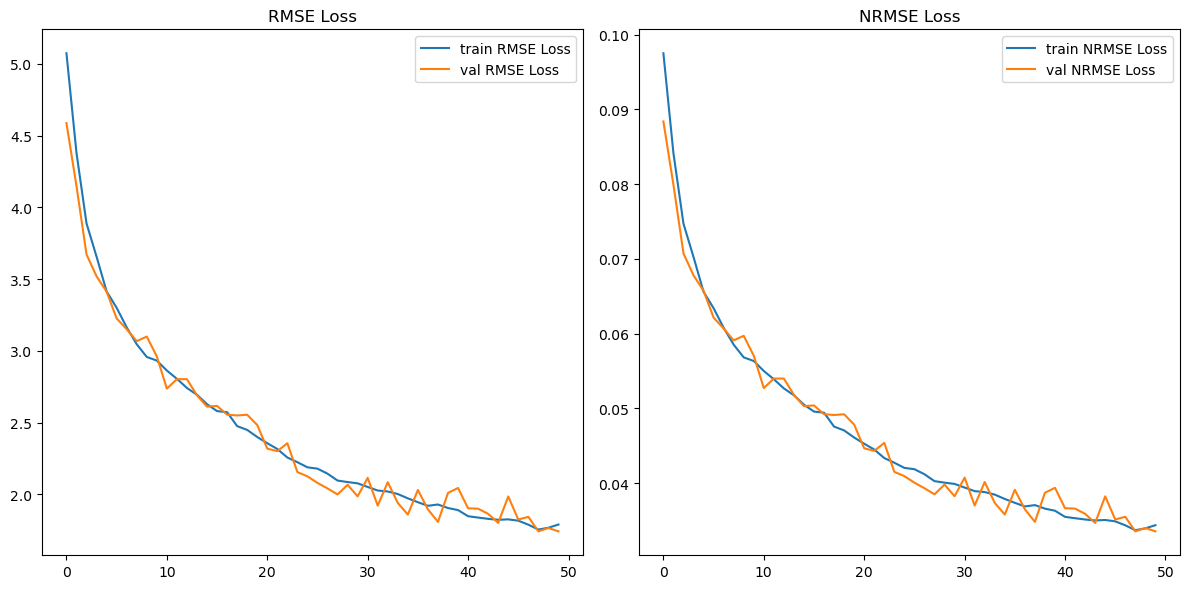

In [24]:
fig1, axs = plt.subplots(1, 2, figsize=(12, 6))
train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list
axs[0].plot(train_RMSELoss_list, label='train RMSE Loss')
axs[0].plot(val_RMSELoss_list, label='val RMSE Loss')
axs[0].set_title("RMSE Loss")
axs[0].legend()

axs[1].plot(train_NRMSELoss_list, label='train NRMSE Loss')
axs[1].plot(val_NRMSELoss_list, label='val NRMSE Loss')
axs[1].set_title("NRMSE Loss")
axs[1].legend()

plt.tight_layout()  # 调整布局以防止重叠
plt.show()

# Result

In [25]:
def draw_pic(x, y, coords):
    # 计算所有子图中颜色值的全局最小值和最大值
    vmin = min([x[i].min() for i in range(5)] + [y[i].min() for i in range(5)])
    vmax = max([x[i].max() for i in range(5)] + [y[i].max() for i in range(5)])

    fig1, axs = plt.subplots(1, 5, figsize=(30, 6), sharey=True)
    for i in range(5):
        im = axs[i].scatter(coords[:, 0], coords[:, 1], s=5, c=x[i], cmap='bwr', vmin=vmin, vmax=vmax)
        axs[i].set_title('input')
    fig1.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical')
    plt.show()
    plt.close()

    fig2, axs = plt.subplots(1, 5, figsize=(30, 6), sharey=True)
    for i in range(5):
        im = axs[i].scatter(coords[:, 0], coords[:, 1], s=5, c=y[i], cmap='bwr', vmin=vmin, vmax=vmax)
        axs[i].set_title('recon')
    fig2.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical')
    plt.show()
    plt.close()

# 示例使用方式
# x = [np.random.randn(100) for _ in range(5)]
# y = [np.random.randn(100) for _ in range(5)]
# coords = np.random.randn(100, 2)
# draw_pic(x, y, coords)


In [26]:
clusters = torch.load('/home/wl4023/github repos/IRP/clusters.pt')
centroids = torch.load('/home/wl4023/github repos/IRP/centroids.pt')
# num_mp_layers = [2, 2, 2]

In [28]:
gae = GAE(1, 16, 1, 2, num_mp_layer, lengthscales, bounding_box)
criterion = RMSELoss()
metric = NRMSE(test_tensor)
# 加载保存的状态字典
state_dict = torch.load('/home/wl4023/github repos/IRP/GAE_kmeans.pth')
gae.load_state_dict(state_dict)

<All keys matched successfully>

In [29]:
for param in gae.parameters():
    param.requires_grad = False

In [32]:
gae.eval()
y = torch.zeros_like(test_tensor)
test_RMSE_Loss = []
test_NRMSE_Loss = []
with torch.no_grad():
    ave_rmse = 0
    ave_nrmse = 0
    for batch in test_loader:
        # batch = batch.to(device)

        input = preprocessor.transform(batch.x)
        predict, _ = gae(input, batch.edge_index, batch.edge_attr, batch.pos, batch.batch)

        
        y[i] = preprocessor.inverse_transform(predict)
        rmse = criterion(test_tensor[i], y[i]).item()
        nrmse = metric(test_tensor[i], y[i]).item()

        test_RMSE_Loss.append(rmse)
        test_NRMSE_Loss.append(nrmse)

        ave_rmse += rmse
        ave_nrmse += nrmse

ave_rmse /= len(test_tensor)
ave_nrmse /= len(test_tensor)


print(f"RMSE loss: {ave_rmse}")
print(f"NRMSE loss: {ave_nrmse}")
    

RMSE loss: 2.687908728122711
NRMSE loss: 0.15285442300140858


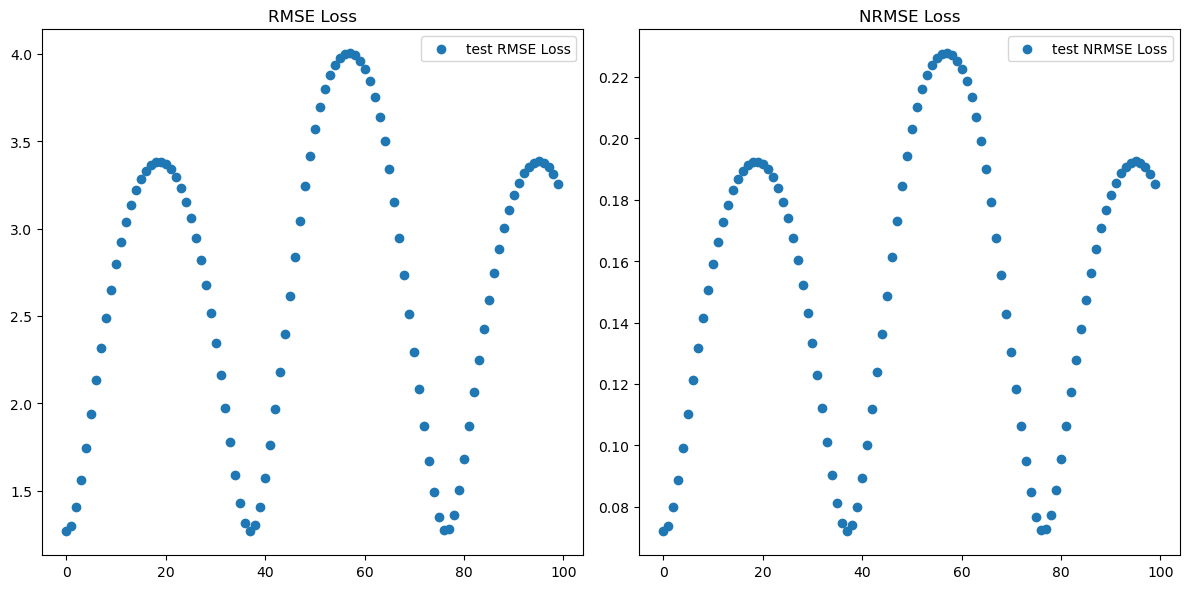

In [33]:
test_RMSE_Loss = np.array(test_RMSE_Loss)
test_NRMSE_Loss = np.array(test_NRMSE_Loss)

# 保存数组到 .npy 文件
np.save('test_rmse.npy', test_RMSE_Loss)
np.save('test_nrmse.npy', test_NRMSE_Loss)


fig1, axs = plt.subplots(1, 2, figsize=(12, 6))

x = np.arange(0, 100)

axs[0].scatter(x, test_RMSE_Loss, label='test RMSE Loss')
axs[0].set_title("RMSE Loss")
axs[0].legend()

axs[1].scatter(x, test_NRMSE_Loss, label='test NRMSE Loss')
axs[1].set_title("NRMSE Loss")
axs[1].legend()


plt.tight_layout()  # 调整布局以防止重叠
plt.show()

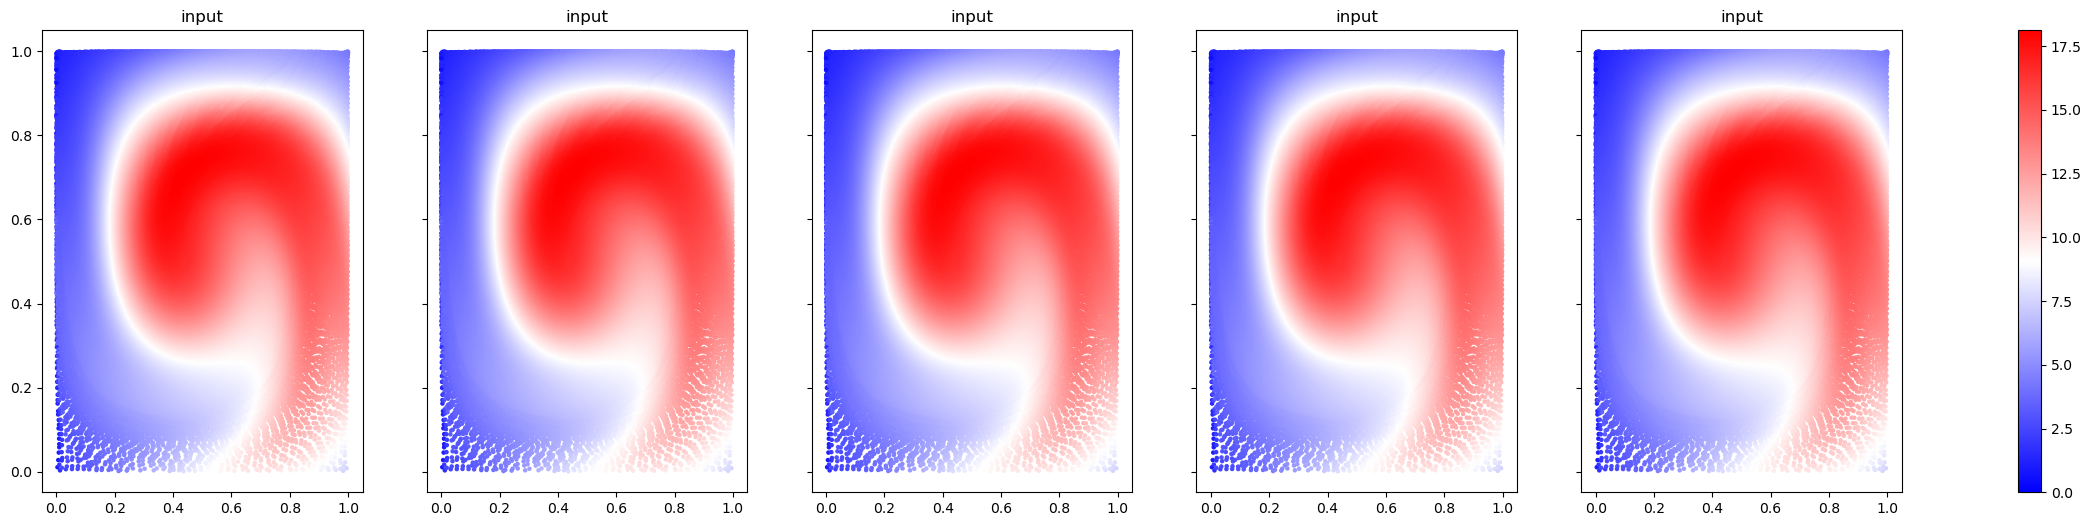

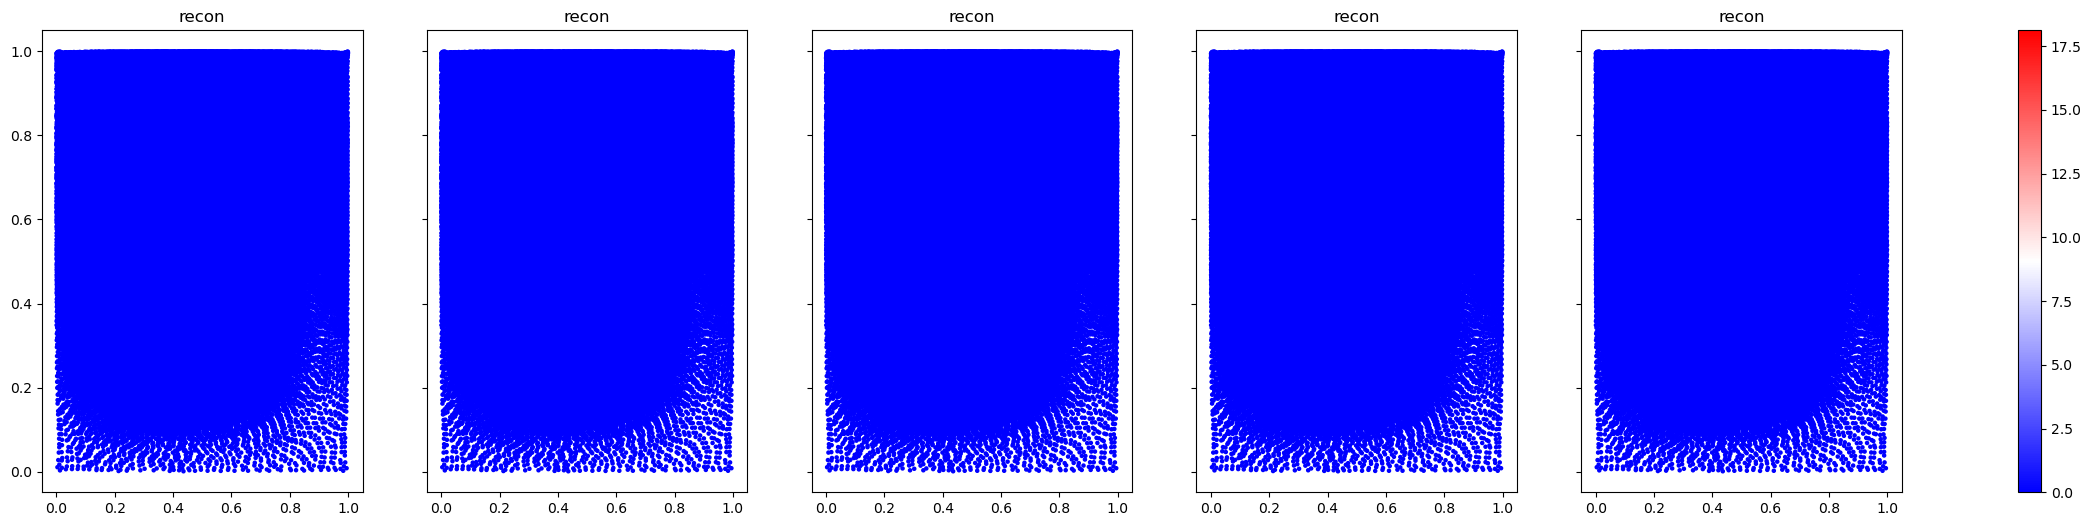

In [35]:
x = test_tensor[-5:]
recon_x = y[-5:]


x_np = x.cpu().detach().numpy()
recon_x_np = recon_x.cpu().detach().numpy()
pos_np = pos.cpu().detach().numpy()
draw_pic(x_np, recon_x_np, pos_np)